In [1]:
import copy

import numpy as np
import pandas as pd
from scipy import stats
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from tqdm import tqdm
import torch

from utils.accs import train_models
from utils.options import args_parser
from utils.utils import exp_details, get_train_test, get_model, get_dataset_and_label_names, add_noise, average_weights
from utils.update import LocalUpdate, test_inference
from utils.sampling import dominant_label_sampling, dirichlet_sampling, iid_sampling

from itertools import product

In [2]:
args = args_parser(default=True)

args.local_ep = 1
args.supervision = True
args.num_users = 100
args.frac = 0.1

# args.lr = 1e-3
# args.dataset = "cifar"
# args.arch = "cnn"

args.lr = 1e-4
args.dataset = "mnist"
args.arch = "mlp"

exp_details(args)


Experimental details:

Reinforcement Arguments:
    Steps Before PPO Update : 256
    PPO Learning Rate       : 0.0003
    PPO Discount Factor     : 0.9
    PPO Batch Size          : 16
    PPO Total Timesteps     : 15000
    Target Accuracy         : 0.95

Federated Arguments:
    Number of Users         : 100
    Fraction of Users       : 0.1
    Local Epochs            : 1
    Local Batch Size        : 32
    Learning Rate           : 0.0001
    Momentum                : 0.5
    Optimizer               : adam

Model Arguments:
    Supervision             : True
    Architecture            : mlp

Misc. Arguments:
    Dataset                 : mnist
    Number of GPUs          : 1
    IID                     : 0
    Random Seed             : 1
    Test Fraction           : 1
    Save Path               : ../../save
    Data Path               : ../../data



In [3]:
plt.style.use("seaborn-darkgrid")
%config InlineBackend.figure_format = 'svg'

In [16]:
from torch.multiprocessing import Pool, set_start_method

try:
     set_start_method('spawn')
except RuntimeError:
    pass

trial_accs = []

with Pool(8) as p:
    results = p.starmap(train_models, [(args, f"cuda:{i}") for i in range(8)])

Performing client sampling...
Performing client sampling...
Performing client sampling...
Performing client sampling...
Performing client sampling...
Performing client sampling...
Performing client sampling...
Performing client sampling...


 23%|██▎       | 23/100 [00:00<00:00, 221.26it/s]

cuda:3 | starting training for gaussian, 0.1
Performing client sampling...


 23%|██▎       | 23/100 [00:00<00:00, 225.99it/s]

cuda:4 | starting training for gaussian, 0.1
Performing client sampling...


 22%|██▏       | 22/100 [00:00<00:00, 214.92it/s]

cuda:6 | starting training for gaussian, 0.1
Performing client sampling...


  0%|          | 0/100 [00:00<?, ?it/s]

cuda:7 | starting training for gaussian, 0.1
Performing client sampling...


 23%|██▎       | 23/100 [00:00<00:00, 224.60it/s]

cuda:0 | starting training for gaussian, 0.1
Performing client sampling...


 22%|██▏       | 22/100 [00:00<00:00, 218.16it/s]

cuda:1 | starting training for gaussian, 0.1
Performing client sampling...


 23%|██▎       | 23/100 [00:00<00:00, 220.67it/s]

cuda:2 | starting training for gaussian, 0.1
Performing client sampling...


 23%|██▎       | 23/100 [00:00<00:00, 222.31it/s]

cuda:5 | starting training for gaussian, 0.1
Performing client sampling...


 22%|██▏       | 22/100 [00:00<00:00, 217.14it/s]

cuda:3 | starting training for gaussian, 0.01
Performing client sampling...


 22%|██▏       | 22/100 [00:00<00:00, 219.37it/s]

cuda:4 | starting training for gaussian, 0.01
Performing client sampling...


 22%|██▏       | 22/100 [00:00<00:00, 213.79it/s]

cuda:6 | starting training for gaussian, 0.01
Performing client sampling...


 22%|██▏       | 22/100 [00:00<00:00, 212.71it/s]

cuda:7 | starting training for gaussian, 0.01
Performing client sampling...


 22%|██▏       | 22/100 [00:00<00:00, 213.98it/s]

cuda:0 | starting training for gaussian, 0.01
Performing client sampling...


 22%|██▏       | 22/100 [00:00<00:00, 212.70it/s]

cuda:1 | starting training for gaussian, 0.01
Performing client sampling...


 21%|██        | 21/100 [00:00<00:00, 208.69it/s]

cuda:2 | starting training for gaussian, 0.01
Performing client sampling...


 22%|██▏       | 22/100 [00:00<00:00, 217.44it/s]

cuda:5 | starting training for gaussian, 0.01
Performing client sampling...


 22%|██▏       | 22/100 [00:00<00:00, 216.18it/s]

cuda:3 | starting training for gaussian, 0.001
Performing client sampling...


 23%|██▎       | 23/100 [00:00<00:00, 221.91it/s]

cuda:4 | starting training for gaussian, 0.001
Performing client sampling...


 22%|██▏       | 22/100 [00:00<00:00, 213.10it/s]

cuda:6 | starting training for gaussian, 0.001
Performing client sampling...


100%|██████████| 100/100 [00:00<00:00, 317.23it/s]

cuda:7 | starting training for gaussian, 0.001
Performing client sampling...



 22%|██▏       | 22/100 [00:00<00:00, 215.19it/s]

cuda:0 | starting training for gaussian, 0.001
Performing client sampling...


 14%|█▍        | 14/100 [00:00<00:00, 135.36it/s]

cuda:1 | starting training for gaussian, 0.001
Performing client sampling...


 22%|██▏       | 22/100 [00:00<00:00, 210.71it/s]

cuda:2 | starting training for gaussian, 0.001
Performing client sampling...


 22%|██▏       | 22/100 [00:00<00:00, 214.35it/s]

cuda:5 | starting training for gaussian, 0.001
Performing client sampling...


100%|██████████| 100/100 [00:00<00:00, 318.51it/s]

cuda:3 | starting training for gaussian, 0.0
Performing client sampling...



 22%|██▏       | 22/100 [00:00<00:00, 219.35it/s]

cuda:4 | starting training for gaussian, 0.0
Performing client sampling...


 22%|██▏       | 22/100 [00:00<00:00, 211.60it/s]

cuda:6 | starting training for gaussian, 0.0
Performing client sampling...


100%|██████████| 100/100 [00:00<00:00, 314.84it/s]

cuda:7 | starting training for gaussian, 0.0
Performing client sampling...



 22%|██▏       | 22/100 [00:00<00:00, 215.52it/s]

cuda:0 | starting training for gaussian, 0.0
Performing client sampling...


100%|██████████| 100/100 [00:00<00:00, 322.53it/s]

cuda:1 | starting training for gaussian, 0.0
Performing client sampling...



 22%|██▏       | 22/100 [00:00<00:00, 213.55it/s]

cuda:2 | starting training for gaussian, 0.0
Performing client sampling...


 22%|██▏       | 22/100 [00:00<00:00, 217.30it/s]

cuda:5 | starting training for gaussian, 0.0
Performing client sampling...


 22%|██▏       | 22/100 [00:00<00:00, 216.01it/s]

cuda:3 | starting training for laplacian, 0.1
Performing client sampling...


 23%|██▎       | 23/100 [00:00<00:00, 221.04it/s]

cuda:4 | starting training for laplacian, 0.1
Performing client sampling...


 22%|██▏       | 22/100 [00:00<00:00, 212.95it/s]

cuda:7 | starting training for laplacian, 0.1
Performing client sampling...


 22%|██▏       | 22/100 [00:00<00:00, 212.21it/s]

cuda:6 | starting training for laplacian, 0.1
Performing client sampling...


 22%|██▏       | 22/100 [00:00<00:00, 217.19it/s]

cuda:0 | starting training for laplacian, 0.1
Performing client sampling...


 22%|██▏       | 22/100 [00:00<00:00, 210.82it/s]

cuda:1 | starting training for laplacian, 0.1
Performing client sampling...


 22%|██▏       | 22/100 [00:00<00:00, 213.76it/s]

cuda:2 | starting training for laplacian, 0.1
Performing client sampling...


100%|██████████| 100/100 [00:00<00:00, 313.57it/s]

cuda:5 | starting training for laplacian, 0.1
Performing client sampling...



 22%|██▏       | 22/100 [00:00<00:00, 215.79it/s]

cuda:3 | starting training for laplacian, 0.01
Performing client sampling...


 23%|██▎       | 23/100 [00:00<00:00, 221.43it/s]

cuda:4 | starting training for laplacian, 0.01
Performing client sampling...


 21%|██        | 21/100 [00:00<00:00, 205.30it/s]

cuda:7 | starting training for laplacian, 0.01
Performing client sampling...


100%|██████████| 100/100 [00:00<00:00, 312.35it/s]

cuda:6 | starting training for laplacian, 0.01
Performing client sampling...



 22%|██▏       | 22/100 [00:00<00:00, 217.15it/s]

cuda:0 | starting training for laplacian, 0.01
Performing client sampling...


100%|██████████| 100/100 [00:00<00:00, 320.46it/s]

cuda:1 | starting training for laplacian, 0.01
Performing client sampling...



100%|██████████| 100/100 [00:00<00:00, 318.34it/s]

cuda:2 | starting training for laplacian, 0.01
Performing client sampling...



 22%|██▏       | 22/100 [00:00<00:00, 212.26it/s]

cuda:5 | starting training for laplacian, 0.01
Performing client sampling...


 21%|██        | 21/100 [00:00<00:00, 206.41it/s]

cuda:3 | starting training for laplacian, 0.001
Performing client sampling...


 22%|██▏       | 22/100 [00:00<00:00, 216.42it/s]

cuda:4 | starting training for laplacian, 0.001
Performing client sampling...


100%|██████████| 100/100 [00:00<00:00, 322.83it/s]

cuda:7 | starting training for laplacian, 0.001
Performing client sampling...



 20%|██        | 20/100 [00:00<00:00, 192.89it/s]

cuda:6 | starting training for laplacian, 0.001
Performing client sampling...


 22%|██▏       | 22/100 [00:00<00:00, 217.66it/s]

cuda:0 | starting training for laplacian, 0.001
Performing client sampling...


 22%|██▏       | 22/100 [00:00<00:00, 213.83it/s]

cuda:1 | starting training for laplacian, 0.001
Performing client sampling...


 22%|██▏       | 22/100 [00:00<00:00, 215.12it/s]

cuda:2 | starting training for laplacian, 0.001
Performing client sampling...


 22%|██▏       | 22/100 [00:00<00:00, 216.62it/s]

cuda:5 | starting training for laplacian, 0.001
Performing client sampling...


100%|██████████| 100/100 [00:00<00:00, 321.82it/s]

cuda:7 | starting training for laplacian, 0.0
cuda:3 | starting training for laplacian, 0.0
cuda:0 | starting training for laplacian, 0.0
cuda:2 | starting training for laplacian, 0.0
cuda:4 | starting training for laplacian, 0.0
cuda:6 | starting training for laplacian, 0.0
cuda:5 | starting training for laplacian, 0.0
cuda:1 | starting training for laplacian, 0.0


In [18]:
np.save("results.npy", results)

In [4]:
results = np.load("results_mnist_acc_100_rounds_1e-4.npy")

# results = np.load("results_cifar_acc_500_rounds_1e-3.npy")

means = np.mean(results, axis=0)
stds = np.std(results, axis=0)

     0.1 gaussian   | Final Acc: 0.21
    0.01 gaussian   | Final Acc: 0.69
   0.001 gaussian   | Final Acc: 0.81
     0.1 laplacian  | Final Acc: 0.21
    0.01 laplacian  | Final Acc: 0.57
   0.001 laplacian  | Final Acc: 0.81


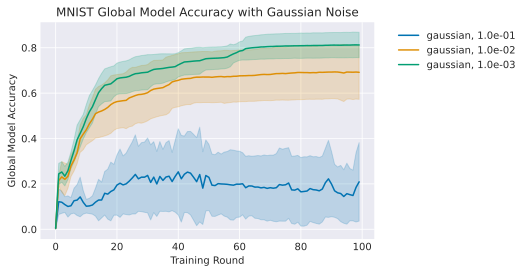

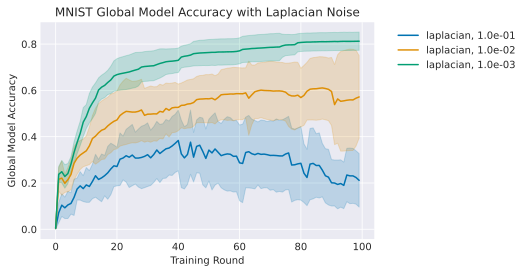

In [5]:
noise_types = ['gaussian', 'laplacian']
noise_scales = [1e-1, 1e-2, 1e-3, 0.0]

palette = sns.color_palette("colorblind")


for this_type in noise_types:
    fig, ax = plt.subplots()
    
    i = 0
    for mean, std, (noise_type, noise_scale) in zip(means, stds, product(noise_types, noise_scales)):
        if noise_type != this_type:
            continue
        color = palette[i]
        if noise_scale != 0:
            ax.plot(mean, label=f"{noise_type}, {noise_scale:.1e}", c=color)
            ax.fill_between(range(results.shape[-1]), mean - std, mean + std, color=color, alpha=0.2)
            print(f"{noise_scale:8} {noise_type:10} | Final Acc: {mean[-1]:.2f}")
        else:
            pass
    #         ax.plot(accs, label=f"no noise", c=color)
    #         print(f"         No Noise   | Final Acc: {mean[-1]:.2f}")
        
        i += 1

    ax.set_xlabel("Training Round")
    ax.set_ylabel("Global Model Accuracy")
    ax.set_title(f"MNIST Global Model Accuracy with {this_type.title()} Noise")

    ax.legend(bbox_to_anchor=(1.45, 1), loc='upper right')
    fig.show()
    plt.savefig(f"figures/acc_{args.dataset}_{this_type}.svg", bbox_inches='tight')